In [49]:
from copy import deepcopy
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from Bio import Phylo, AlignIO

# Building a phylogenetic tree

To investigate evolutionary relationships between sequences in the alignment, we have to reconstruct the phylogenetic tree that approximates the evolutionary history of the viruses whose genomes we are analyzing. There are several commonly used tools for this, including

 - IQtree
 - RAxML
 - FastTree

We will use IQtree here, which can again be installed with `conda` via `conda install -c bioconda iqtree`. 

We can call IQtree (the program has looooots of options) via 
```bash
iqtree -s <input_alignment> -m GTR
```
The flag `-m GTR` tells IQtree to use a general-time-reversible substitution model.

After running the command, you'll find a number of files in your directory. 

```txt
<input_alignment>.fasta.bionj
<input_alignment>.fasta.ckp.gz
<input_alignment>.fasta.iqtree
<input_alignment>.fasta.log
<input_alignment>.fasta.mldist
<input_alignment>.fasta.treefile
```
Some of the are log files, or checkpoints to restart the analysis. The file we care most about is the file ending in `.treefile`. It contains the reconstructed tree in [`newick` format](https://en.wikipedia.org/wiki/Newick_format). 




## visualizing the tree

There are many excellent tools for visualizing phylogenetic tree. A very convenient one is [Auspice](https://auspice.us/), which is a web-based tool that allows you to visualize and explore phylogenetic trees interactively.

After changing the file extension of the `.treefile` to `.nwk`, upload the file and explore the tree.

Phylogenetic analysis often require integrating the phylogenetic tree with other information such as phenotype, geographic location, collection date... For the data at hand, you can also upload the metadata `csv` file generated previously, which lets you also color the tree by metadata.

![auspice](assets/auspice.png)

# Manipulating trees with Biopython

Biopython provides a library with a number of very useful basic function that allow you to work with phylogenetic trees.

Let's load an visualize the tree. You can use the `read` and `draw` function for this.

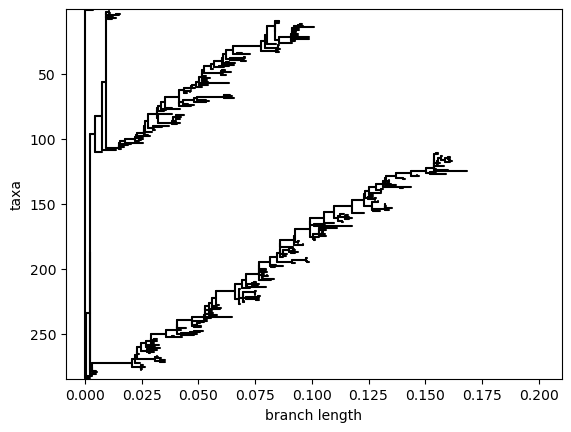

In [50]:
tree = Phylo.read("results/tree.nwk", "newick")

Phylo.draw(tree, label_func=lambda x: None)

### Ladderization

"Ladderizing" a tree involves sorting the children of each node such that the total number of subtending tips of each clade are ascending or descending. From a topological perspective, tree with rotated tips are equivalent. For display purposes, it often makes sense to decide on a particular ordering. Biophytion implements a ladderize routine.

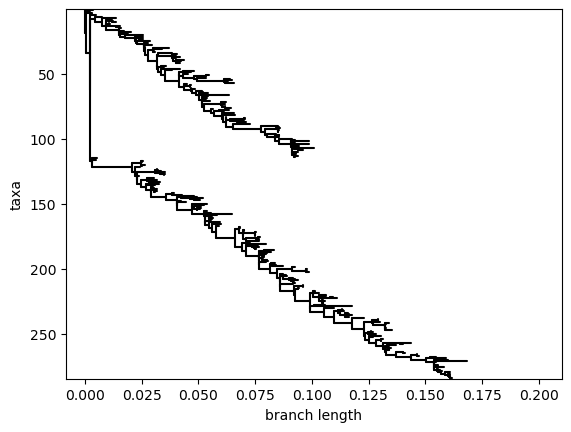

In [51]:
tree.ladderize()
Phylo.draw(tree, label_func=lambda x: None)

## Rooting the tree

Another important decision when it comes to analyzing phylogenetic trees is the placement of the root. This decides the direction of time along the branches.

There are several ways to root a tree. We will discuss them in more detail in the next section. For now, we will root the tree using the oldest sequence in the dataset as an outgroup.


In [52]:
metadata = pd.read_csv("results/h3n2_metadata.csv", parse_dates=["date"], index_col=0)
metadata.sort_values("date").head()

,description,date,country,len,ambiguous,collection_year
accession,,,,,,
CY034012.1,Influenza A virus (A/Hong Kong/1-6-MA21-2/1968...,1968-01-01,Hong Kong,1715,0,1968
CY033553.1,Influenza A virus (A/Hong Kong/1-11-MA21-3/196...,1968-01-01,Hong Kong,1719,0,1968
CY033017.1,Influenza A virus (A/Hong Kong/1-4/1968(H3N2))...,1968-01-01,Hong Kong,1720,0,1968
CY033988.1,Influenza A virus (A/Hong Kong/1-1-MA-12D/1968...,1968-01-01,Hong Kong,1719,0,1968
CY146809.1,Influenza A virus (A/Victoria/JY2/1968(H3N2)) ...,1968-01-01,Australia,1743,0,1968


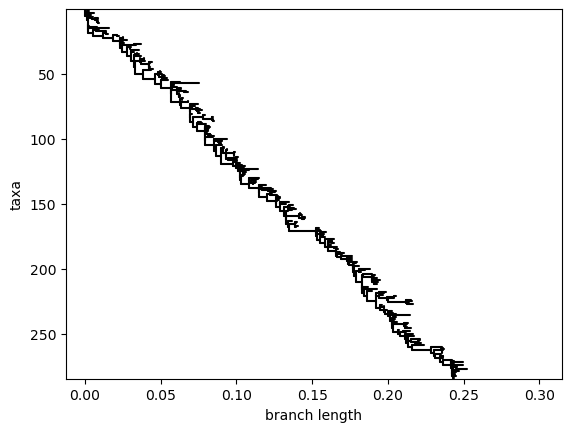

1

In [53]:
# we can use one of the original Hong-Kong sequences as an outgroup
outgroup = "CY034012.1"

tree.root_with_outgroup(outgroup)
tree.ladderize()
Phylo.draw(tree, label_func=lambda x: None)

# save for later visualizations
Phylo.write(tree, "results/tree_rooted.nwk", "newick")

## Tree traversal

Unlike lists, trees are not linear data structures, but rather hierarchical data structures. Many of the algorithms that operate on trees require you to visit all nodes, but there is no single order in which to do this, and the order often matters.

There are several common ways to [traverse a tree](https://en.wikipedia.org/wiki/Tree_traversal):

 - **pre-order**: visit the parents before its children, starting at the root.
   This is often useful if the information needed at a node can be calculated from the information of its parent. (E.g. distance from the root).
 - **post-order**: visit children before its parent
   Useful if the information needed at a node can be calculated from the information of its children. (E.g. number of leaves below a node).
 - level or **breadth-first** traversal: root -> children of the root -> grand-children of the root -> ...

![tree traversal](assets/tree_traversal.png)
![level traversal](assets/level_traversal.png)

Pre-order and post-order traversal are at the heart of many efficient recursive algorithms.


### Simple example: calculate the number of leaves below each node. 

If we want to calculate the number of leaves below each internal node, we can use a post-order traversal. We can assign to each terminal node `n_leaves=1`, and for each internal node, we can sum the number of leaves of its children.


In [54]:
def calculate_n_leaves(tree):
    """Assign the number of leaves to each internal node"""
    T = deepcopy(tree)
    for node in T.find_clades(order="postorder"):
        if node.is_terminal():
            node.n_leaves = 1
        else:
            node.n_leaves = sum(child.n_leaves for child in node.clades)
    return T

T = calculate_n_leaves(tree)
print("total n. leaves:", T.root.n_leaves)

total n. leaves: 284


### Simple example: calculate the distance to the root.

If we want to calculate the distance of each internal node to the root, we can use a pre-order traversal. We can assign `distance=0` to the root, and for each other node we can set its `distance` equal to the distance of its parent plus the node branch length.

In [55]:
def calculate_root_to_tip_distance(tree):
    T = deepcopy(tree)

    T.root.distance = 0
    for node in T.get_nonterminals(order="preorder"):
        for child in node.clades:
            child.distance = node.distance + child.branch_length
    
    return T

# calculate root-to-tip distances
T = calculate_root_to_tip_distance(tree)
rtt_distances = {l.name: l.distance for l in T.get_terminals()}
print("root-to-tip distances:")
print(rtt_distances)
    

root-to-tip distances:
{'CY034012.1': 0.0, 'CY033988.1': 0.0023537518, 'CY112257.1': 0.0058848196, 'CY019899.1': 0.0035270925, 'CY021837.1': 0.0041145559000000005, 'CY113045.1': 0.0052905938, 'CY112265.1': 0.008830359999999999, 'CY112273.1': 0.0088248107, 'CY021117.1': 0.0088234043, 'CY021085.1': 0.0088248601, 'CY022938.1': 0.009411270000000001, 'CY033017.1': 0.0017646648999999999, 'CY033553.1': 0.002352331, 'CY006299.1': 0.0076662506000000005, 'CY006683.1': 0.016007763300000002, 'CY112281.1': 0.009432282299999999, 'CY002496.1': 0.0141705772, 'CY021597.1': 0.014198707799999998, 'CY113069.1': 0.015372717999999999, 'CY009356.1': 0.0213317632, 'CY113085.1': 0.0225070569, 'CY008460.1': 0.0248862234, 'CY008684.1': 0.0248862234, 'CY113101.1': 0.028011152899999996, 'CY077820.1': 0.025062043699999998, 'CY003528.1': 0.025651030699999997, 'CY113173.1': 0.036937962000000005, 'CY021093.1': 0.0333592053, 'CY113109.1': 0.0303743819, 'CY121181.1': 0.0297883796, 'CY147430.1': 0.0297883796, 'CY113141.1

# Consistency check: alignment distance vs tree distance

When reconstructing a phylogenetic tree, the algorithm tries to maximize the likelihood of the tree given the alignment. This means that the distance between two sequences in the alignment should be closely related to the distance between the two sequences in the tree.

We can check that this is the case by calculating these two distances:
- sequence divergence can be calculated from the hamming distance in alignment
- distances of leaves on the tree can be calculated using the `distance` method of the tree object.

Look at the joint distribution of the two distances. What do you observe? Why is it not linear?

In [56]:
from itertools import combinations


aln = AlignIO.read("results/h3n2_coding.aln.fa", "fasta")
ids = [rec.id for rec in aln]
A = np.array(aln)
aln_divergence = []
for i, j in combinations(range(len(ids)), 2):
    idxi = ids[i]
    idxj = ids[j]
    if idxi > idxj:
        idxi, idxj = idxj, idxi
    seqi = A[i]
    seqj = A[j]
    div = np.mean(seqi != seqj)
    aln_divergence.append({
        "id1": idxi,
        "id2": idxj,
        "aln_divergence": div,
    })
aln_divergence = pd.DataFrame(aln_divergence).set_index(["id1", "id2"])
aln_divergence

aln_divergence
id1        id2                       
CY013919.1 CY038959.1        0.012956
CY038663.1 CY038959.1        0.010012
CY013525.1 CY038959.1        0.013545
CY006115.1 CY038959.1        0.014723
CY038959.1 OP511830.1        0.072438
...                               ...
CY006691.1 CY020325.1        0.001767
           CY006707.1        0.002945
CY006699.1 CY020325.1        0.004711
           CY006707.1        0.004711
CY006707.1 CY020325.1        0.003534

[40186 rows x 1 columns]

In [57]:
# calculate tree distances
tree_distances = []
for i, j in combinations(tree.get_terminals(), 2):
    idxi = i.name
    idxj = j.name
    if idxi > idxj:
        idxi, idxj = idxj, idxi
    dist = tree.distance(i, j)
    tree_distances.append({
        "id1": idxi,
        "id2": idxj,
        "tree_distance": dist,
    })
tree_distances = pd.DataFrame(tree_distances).set_index(["id1", "id2"])
tree_distances

,,tree_distance
id1,id2,
CY033988.1,CY034012.1,0.002354
CY034012.1,CY112257.1,0.005885
CY019899.1,CY034012.1,0.003527
CY021837.1,CY034012.1,0.004115
CY034012.1,CY113045.1,0.005291
...,...,...
PP619459.1,PP904074.1,0.002954
PP685646.1,PP904074.1,0.001772
PP619459.1,PQ412865.1,0.002955


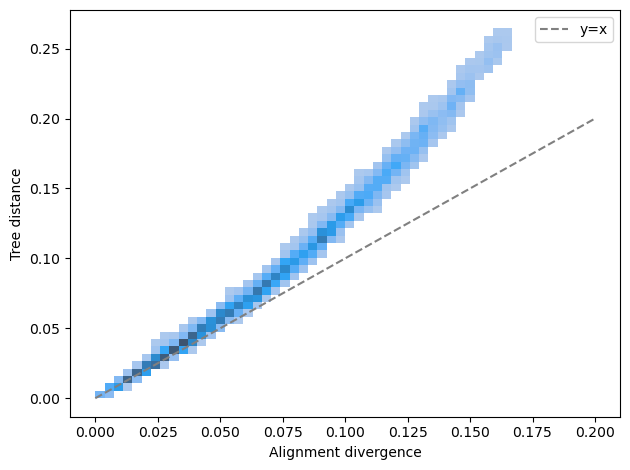

In [58]:
# merge the two dataframes
dist = aln_divergence.join(tree_distances)

# scatter-plot the two distances
sns.histplot(data=dist, x="aln_divergence", y="tree_distance")
# plot diagonal
plt.plot([0, 0.2], [0, 0.2], color="gray", linestyle="--", label="y=x")
plt.xlabel("Alignment divergence")
plt.ylabel("Tree distance")
plt.legend()
plt.tight_layout()
plt.show()

# Parsimonious ancestral state reconstruction: Fitch-parsimony

In [59]:
leaves_states = metadata["country"].to_dict()

def fitch_parsimony(tree, leaves_states):

    # set state of the leaves
    for leaf in tree.get_terminals():
        leaf.state = set([leaves_states[leaf.name]])
    
    # postorder traversal
    for node in tree.get_nonterminals(order="postorder"):
        # get the states of the children
        children_states = [child.state for child in node.clades]
        # find the intersection of the states
        intersection = set.intersection(*children_states)
        # if there is no intersection, take the union
        if not intersection:
            node.state = set.union(*children_states)
        else:
            node.state = intersection

    print("Preorder traversal terminated")
    print("Root states:", tree.root.state)

    # set the state of the root by picking one of the possible states
    tree.root.state = tree.root.state.pop()
    print("Root state set to:", tree.root.state)
    tree.root.transition = ""

    # preorder traversal
    for node in tree.get_nonterminals(order="preorder"):
        for child in node.clades:
            # if the child state is not in the node state, set the node state to the child state
            if node.state in child.state:
                child.state = node.state
                child.transition = ""
            else:
                child.state = child.state.pop()
                child.transition = f"{node.state} -> {child.state}"
    
    print("Preorder traversal terminated")
            
fitch_parsimony(tree, leaves_states)


Preorder traversal terminated
Root states: {'Hong Kong'}
Root state set to: Hong Kong
Preorder traversal terminated


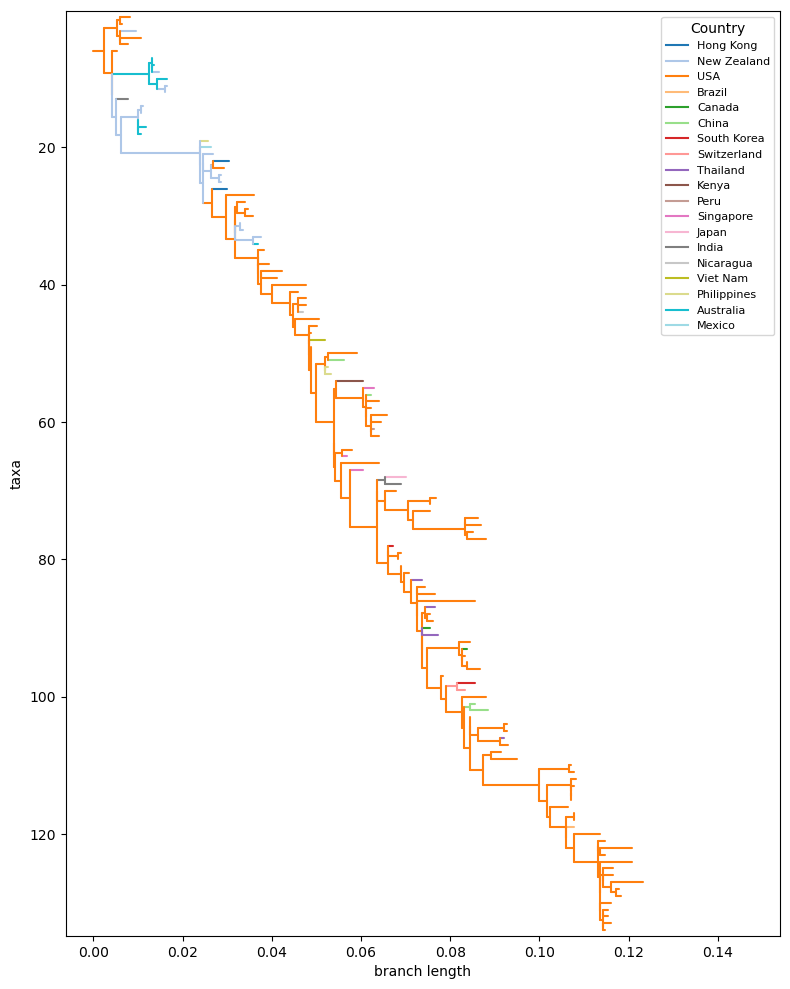

In [60]:

# restrict to recent part of the tree
recent = metadata["date"] > pd.Timestamp("2000-01-01")
recent_idxs = metadata[recent].index
recent_tree = tree.common_ancestor(recent_idxs)

# colormap for contries
recent_countries = metadata.loc[recent_idxs]["country"].unique()
cmap = plt.get_cmap("tab20", len(recent_countries))
country_colors = {country: mpl.colors.to_hex(cmap(i)) for i, country in enumerate(recent_countries)}


# set the color of the nodes based on the country
for node in recent_tree.find_clades(order="postorder"):
    if node.state in country_colors:
        node.color = country_colors[node.state]
    else:
        node.color = "gray"

fig, ax = plt.subplots(figsize=(8, 10))
# Phylo.draw(recent_tree, branch_labels=lambda n:n.transition, label_func=lambda n:'', axes=ax, do_show=False)
Phylo.draw(recent_tree, label_func=lambda n:'', axes=ax, do_show=False)
for country, color in country_colors.items():
    ax.plot([], [], color=color, label=country)
ax.legend(title="Country", loc="upper right", fontsize=8)
plt.tight_layout()
plt.show()


### Problems with this approach

- we don't really know the directionality of the tree. The tree isn't properly rooted (earlier sequences are far to the right)
- the sampling of viruses is very biased
- the algorithms treats each country equally likely, but a virus is much more likely to be from a big rather than a small country. 